# DEA Notebook 

![alt text](../dea-gallery-crop.png "DEA")

### DEA is a Content creation service and no-code platform for DestinE storytelling and data visualization

## From data to story

This notebook can be used to create a simple story on DEA with a slide containing a COG file generated from data provided by the DestinE CacheB service (ERA5 2 metre temperature)

# Install pre-requirements

In [1]:
!pip install matplotlib
!pip install numpy
!pip install xarray
!pip install rasterio
!pip install requests
!pip install rio-cogeo
!pip install rioxarray

  Using cached rio_cogeo-5.3.6-py3-none-any.whl.metadata (4.6 kB)
  Using cached morecantile-5.4.2-py3-none-any.whl.metadata (7.0 kB)
Using cached rio_cogeo-5.3.6-py3-none-any.whl (20 kB)
Using cached morecantile-5.4.2-py3-none-any.whl (49 kB)


# Download the sample NetCDF file and save it in the input folder

DESP CacheB will be used to download an ERA5 t2m data selecting 2024-08-01 as date.

The data will be saved locally in NetCDF format.

**NOTE**: the temporary password is valid for a limited period of time and needs to be regenerated and reconfigured periodically by running the cells above.

The following file will be downlaoded locally: **t2m_era5_20240801.nc**

In [2]:
%%capture cap
%run ./../../cacheb/cacheb-authentication.py

Username:  dea@alia-space.com
Password:  ········


In [3]:
output_1 = cap.stdout.split('}\n')
token = output_1[-1][0:-1]

from pathlib import Path
with open(Path.home() / ".netrc", "a") as fp:
    fp.write(token)

## You can use your own data!

**NOTE:** You can use your own NetCDF file, but please consider that the NetCDF file must have latitude and longitude coordinates defined in the range -180,180,-90,90. 

In case the original file has a different definition, applying, for instance, the following CDO command:
 
 ```
cdo sellonlatbox,-180,180,-90,90 <input_file.nc> <output_file.nc>
```

More info on CDO (Climate Data Operators) are available [here](https://code.mpimet.mpg.de/projects/cdo)

In [4]:
%run ./get_era5_t2m_from_cacheb.py

Data to download...
<xarray.DataArray 't2m' (latitude: 721, longitude: 1440)> Size: 4MB
dask.array<getitem, shape=(721, 1440), dtype=float32, chunksize=(64, 64), chunktype=numpy.ndarray>
Coordinates:
    entireAtmosphere  float32 4B 0.0
  * latitude          (latitude) float64 6kB 90.0 89.75 89.5 ... -89.75 -90.0
    number            int64 8B 0
    surface           float64 8B 0.0
    valid_time        datetime64[ns] 8B 2024-08-01T12:00:00
  * longitude         (longitude) float64 12kB -179.8 -179.5 ... 179.8 180.0
Attributes:
    units:    C
Your file t2m_era5_20240801.nc is ready!


## Wait until your NetCDF file appear in your workspace before executing the next cell. It could take a while.

# Convert NetCDF to GeoTiff

The following file will be downlaoded locally: **t2m_era5_20240801.tiff**

## 1. Define variables

In [5]:
file_path = "t2m_era5_20240801.nc"
tif_path = "t2m_era5_20240801.tiff"

## 2. Import dependencies 

In [6]:
import xarray as xr
import rioxarray

## 3. Open dataset and select variable (e.g. var='t2m')

In [7]:
var = 't2m'
data = xr.open_dataset(file_path)
data = data[var]

## 4. Apply CRS (assuming the coordinates are longitude and latitude)

In [8]:

var = data.rename({'latitude': 'y', 'longitude': 'x'})
var.rio.write_crs("EPSG:4326", inplace=True)


<xarray.DataArray 't2m' (y: 721, x: 1440)> Size: 4MB
[1038240 values with dtype=float32]
Coordinates:
    entireAtmosphere  float32 4B ...
  * y                 (y) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
    number            int64 8B ...
    surface           float64 8B ...
    valid_time        datetime64[ns] 8B ...
  * x                 (x) float64 12kB -179.8 -179.5 -179.2 ... 179.8 180.0
    spatial_ref       int64 8B 0
Attributes:
    units:    C

## 5. Only for not global datasets

If data contains NaN, replace it with -9999 to make them transparent afterwards (as soon as you then map this value to black in the colormap text file)


In [9]:
var_filled = var.fillna(-9999)

## 6. Ruotate data 

it can be necessary to flip data of 180 degrees; verify if this step is necessary to your case

```
var_filled = var_filled[::-1, ::]
```

## 7. Save the transformed data to GeoTiff (intermediate step)

Wait untill the tiff file is created (it could take a while)

In [10]:
var_filled.rio.to_raster(tif_path)

# Apply the colormap to the generated Tiff in grayscale

Matplotlib will be used to achieve this.

The following file will be downlaoded locally: **t2m_era5_20240801_rgb.tiff**

## 1. Load the colormap from the file

The file colormap.txt contains a colormap suitable for temperature in Celsius.

In [11]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Load the colormap from the file
def load_colormap(colormap_file):
    colormap = []
    values = []
    with open(colormap_file, 'r') as f:
        for line in f:
            # Skip empty lines
            if not line.strip():
                continue
            parts = line.strip().split(maxsplit=1)  # Split only at the first space
            value = float(parts[0])
            # Ensure correct parsing of the RGB values
            rgb = tuple(map(int, parts[1].replace(',', ' ').split()))
            values.append(value)
            colormap.append(rgb)
    return values, colormap

values, colormap = load_colormap('colormap.txt')

## 2. Create a custom colormap for matplotlib

In [12]:
def create_colormap(values, colormap):
    norm_values = np.linspace(0, 1, len(values))
    colors = np.array(colormap) / 255.0  # Normalize RGB to [0, 1] range
    return ListedColormap(colors), norm_values

cmap, norm_values = create_colormap(values, colormap)

## 3. Open the grayscale TIFF

In [15]:
with rasterio.open(tif_path) as src:
    grayscale = src.read(1)  # Read the first band

## 4. Apply the colormap

Interpolate the grayscale values to teh colormap

A new Tiff will be generated

In [16]:
output_rgb_tiff = "t2m_era5_20240801_rgb.tiff"

In [17]:
def apply_colormap_to_tiff(input_tiff, output_tiff, values, colormap):
    with rasterio.open(input_tiff) as src:
        grayscale = src.read(1)  # Read the first band (grayscale)
        
        # Apply the colormap to the grayscale data
        normalized = (grayscale - np.min(grayscale)) / (np.max(grayscale) - np.min(grayscale))  # Normalize
        cmap = ListedColormap(np.array(colormap) / 255.0)  # Convert colormap to matplotlib format
        rgb_image = cmap(normalized)

        # Write the RGB image to a new TIFF
        height, width, _ = rgb_image.shape
        profile = src.profile
        profile.update(count=3, dtype=rasterio.uint8)  # Update profile to handle RGB output

        with rasterio.open(output_tiff, 'w', **profile) as dst:
            dst.write((rgb_image[:, :, 0] * 255).astype(np.uint8), 1)
            dst.write((rgb_image[:, :, 1] * 255).astype(np.uint8), 2)
            dst.write((rgb_image[:, :, 2] * 255).astype(np.uint8), 3)

# Apply the colormap (assuming 'values' and 'colormap' were already loaded)
apply_colormap_to_tiff(tif_path, output_rgb_tiff, values, colormap)

# Convert TIFF to COG optimized for web

The following file will be downlaoded locally: **t2m_era5_20240801_web_optimized.tiff**

First of all, import the needed dependencies

In [18]:
import rasterio
from rasterio.enums import Resampling
from rio_cogeo.cogeo import cog_validate, cog_translate
from rio_cogeo.profiles import cog_profiles


## 1. Define paths to your files

In [19]:
output_cog = "t2m_era5_20240801_cog.tiff"
output_cog_web_optimized = "t2m_era5_20240801_web_optimized.tiff"

## 2. Convert the GeoTiff to COG

In [20]:
cog_profile = cog_profiles.get("deflate")  # You can choose other profiles such as "jpeg", "lzw"

config = {
    "blocksize": 512,  # You can customize the blocksize
    "resampling": "average"  # Pass the resampling method as a string
}

with rasterio.open(output_rgb_tiff) as src:
    # Create COG
    cog_translate(
        src,
        output_cog,
        cog_profile,
        config=config,
        nodata=src.nodata,
        overview_level=8,  # Define the overview level
        overview_resampling="average",  # Pass the resampling method as a string
    )

print("COG created successfully!")

Reading input: <open DatasetReader name='t2m_era5_20240801_rgb.tiff' mode='r'>

Adding overviews...
Updating dataset tags...
Writing output to: t2m_era5_20240801_cog.tiff


COG created successfully!


## 3. Convert COG to web-optimized COG using subprocess

In [21]:
import subprocess

subprocess.run([
    "rio", "cogeo", "create", 
    output_cog, 
    output_cog_web_optimized,
    "--blocksize", "512",
    "--overview-resampling", "average",
    "--overview-level", "8",
    "--web-optimized"
], check=True)

print("Web-optimized COG created successfully!")


Defining overview's `blocksize` to match the high resolution `blocksize`: 512


Reading input: /home/jovyan/desp-lab/dea-test/data2story/t2m_era5_20240801_cog.tiff

Adding overviews...
Updating dataset tags...
Writing output to: /home/jovyan/desp-lab/dea-test/data2story/t2m_era5_20240801_web_optimized.tiff


Web-optimized COG created successfully!


**NOTE**: The global COG file may result in missing the data over the poles, as those regions introduce distortions in the visualization.

# Upload the Web-Optimized COG on DEA!

You can now upload the COG file generated on DEA and use it in your stories using the DEA API.

> **_NOTE:_** You have to get a new access token to use the authenticated endpoint of DEA


In [102]:
%%capture cap
%run ./../dea-authentication.py

Type your username:  dea@alia-space.com
Type your password:  ········


In [103]:
output_2 = cap.stdout.split('}\n')
token_dea = output_2[-1][0:-1]

## Add the generated COG file to your DEA asset using DEA API

This file will be stored on your private workspace hosted on the DestinE Platform

> **_NOTE:_** As an alternative, you can upload your asset from DEA Story Editor

![alt text](./user_assets.png "Upload assets")

In [72]:
dea_base_url = "http://dea.destine.eu/"

### Import section

In [81]:
import json
import requests
import urllib.parse
import webbrowser

In [74]:


api_url = "api/userAssets/upload"
joined_url = urllib.parse.urljoin(dea_base_url, api_url)

payload = {'type': 'image/tiff',
'assetType': 'GeoTIFF/COG'}
files=[
  ('file',(output_cog_web_optimized,open(output_cog_web_optimized,'rb'),'image/tiff'))
]
headers = {
  'Authorization': f'Bearer {token_dea}'
}

response = requests.request("POST", joined_url, headers=headers, data=payload, files=files)
userid = ''
numbytes = ''
assetId = ''
response_data = None

if response.status_code == 201:
    print('Asset uploaded succesfully!')
    response_data = response.json()
    userid = response_data['asset']['userId']
    numbytes = response_data['asset']['bytes']
    assetId = response_data['asset']['_id']
else:
    print('Failed to upload asset')
    



print(response)


Asset uploaded succesfully!
<Response [201]>


## Create a story with your asset using DEA API

> **_NOTE:_** As an alternative, you can upload your asset from the [DEA Story Editor](https://dea.destine.eu/web/stories/editor)


{"title": "A sample story", "description": "A story with a user asset", "author": "You", "backgroundImage": "", "isShared": null, "isPublic": null, "categories": [], "position": {"latitude": 41.94900341314554, "longitude": 12.691010729488616}, "slides": [{"title": "Slide 1", "infoBox": "{\"ops\":[{\"insert\":\"This slide contain an asset uploaded via API\\n\"}]}", "slideDurationSeconds": 10, "assets": [{"assetId": "6705bc763863ed3f3cf46a51", "parentAsset": {"_id": "6705bc763863ed3f3cf46a51", "filename": "t2m_era5_20240801_web_optimized.tiff", "name": "t2m_era5_20240801_web_optimized.tiff", "isShared": false, "isPublic": false, "type": "image/tiff", "assetType": "GeoTIFF/COG", "bytes": 189840, "status": "UPLOADED", "userId": "91d390bd-a62c-4e65-bd99-1a21da521bdc", "percentComplete": 100, "progressMessage": "Asset successfully uploaded", "isAlreadySelected": true, "isVisible": true}, "assetMetadata": [], "isVisible": true}], "terrain": null, "captureViewDetails": null, "thumbnail": null,
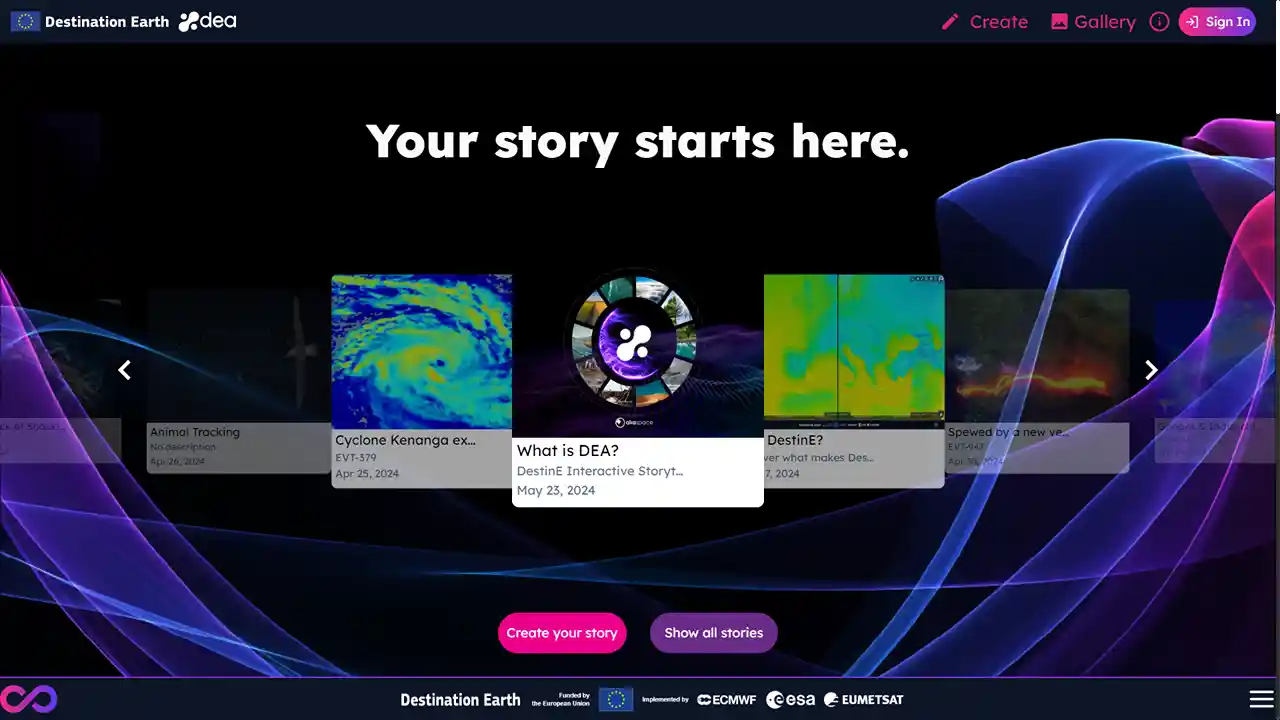

In [104]:


story_url = "api/userStories"
new_url = urllib.parse.urljoin(dea_base_url, story_url)
story_editor_url = urllib.parse.urljoin(dea_base_url, 'web/stories')

# load the sample json template for API request body 
with open('data.json', 'r') as file:
    payload = json.load(file)

# replace tags in the JSON file with the proper asset's metadata
payload_string = json.dumps(payload)
payload_string = payload_string.replace('"<bytes>"', f'{numbytes}')
payload_string = payload_string.replace('<userid>', userid)
payload_string = payload_string.replace('<my_asset>', output_cog_web_optimized)
payload_string = payload_string.replace('<assetId>', assetId)

payload = json.dumps(json.loads(payload_string))

headers = {
  'Content-Type': 'application/json',
  'Authorization': f'Bearer {token_dea}'
}

res = requests.request("POST", new_url, headers=headers, data=payload)
res_data = None
storyId = '' 
story_editor_id_url = f'{story_editor_url}/editor/'

if res.status_code == 201:
    print('Story created succesfully!')
    res_data = res.json()
    storyId = res_data['_id']
    story_editor_id_url = f'{story_editor_url}/editor/{storyId}'
    print(f'You can edit your story at the following URL: {story_editor_id_url}')

else:
    print('Failed to create story') 
    print(res)
    print(res.reason)


## Your story has been created!

You can now continue to write your story from the [DEA Story Editor](https://dea.destine.eu/web/stories/editor).

Your story should look like the picture below:

 ![alt text](./new_story.png "Your new story")

You need to authenticate on the DestinE Platform to edit your story.

 ![alt text](./cover.png "DEA")